In [4]:
using Agents
using CairoMakie
using Distributions
#import DrWatson: @dict

In [5]:
#= The agent class representing one tubulin dimer
    those can polymerize and also hydrolize from GTP to GDP
=#

@agent tubulin GridAgent{2} begin
    polym::Bool
    GDP::Bool
end

In [6]:
#= Main Function to initialize the model=#

function initialize(;Nstarts=1, numagents = 550, 
        griddims = (100,100), 
        p_hyd= 0.001, 
        p_polym = 0.99,
        p_depolym_GTP= 0.005,
        p_depolym_GDP=0.01 )
   
    # Probability to hydrolize from GTP to GDP: 
    P_hyd = Binomial(1,p_hyd)
    # Probability to Polymerize/bind to the microtuble 
    P_polym = Binomial(1,p_polym)
    # Probability to depolimerize if not hydrolized (GTP - tubulin) = lower
    P_depolym_GTP = Binomial(1,1-p_depolym_GTP)
    # Probability to depolimerize if hydrolized (GDP - tubulin) = higher
    P_depolym_GDP = Binomial(1,1-p_depolym_GDP)
    
    
    properties = Dict(:griddims=> griddims,
                    :numagents => numagents,
                    :Nstarts => Nstarts,
                    :p_hyd => p_hyd,
                    :p_polym => p_polym,
                    :p_depolym_GTP => p_depolym_GTP,
                    :p_depolym_GDP => p_depolym_GDP,
                    :P_hyd => P_hyd,
                    :P_polym=> P_polym,
                    :P_depolym_GTP=>  P_depolym_GTP,
                    :P_depolym_GDP=> P_depolym_GDP
                    )
    
    
    space = GridSpace(griddims, periodic= false, metric = :chebyshev)
    
    model = ABM(
        tubulin,space;
        scheduler = Schedulers.randomly,
        properties = properties
    )
    # populize Space
    id = 0
    # Startingpoints:
    for _ in 1:Nstarts
        id += 1
        agent =  tubulin(id,(50,50),true,true)
        if id == 1
            add_agent_pos!(agent,model) # add first staringpoint to center
        else
            add_agent_single!(agent,model) # add additional startingpoints to random positions 
        end
    end
    # unpolimerized (free) agents
    for _ in 1:numagents 
        id += 1
        agent =  tubulin(id,(1,1),false,false)
        add_agent_single!(agent,model) # add agents to random positions
    end
    return model
end

initialize (generic function with 1 method)

In [7]:
#agent step func
function agent_step!(agent,model)
    # Starting points have to stay the same
    if agent.id > model.Nstarts  
        # Logic for unpolymerized agents:
        if agent.polym == false            
            walk!(agent, rand, model, ifempty =true)# brownsche bewegung wenn nicht polymerisiert
            for id in nearby_ids(agent, model, [(1, 1:1), (2, 1:1)]) # check topright neighbour
                # Problem wenn periodisch metrik tuple arg Only possible with Chebyshev spaces.
              #for id in nearby_ids(agent, model,1)
                if model[id].polym # if polymerized
                    agent.polym = rand(model.P_polym,1)[1] # polimerize with P_polym
                end
            end
        end
        # Logic for polymierized agents:
        if agent.polym
            if agent.GDP == false   # if not hydrolized
                agent.GDP = rand(model.P_hyd,1)[1] # hydrolize with P_hyd
            end
            if isempty(tuple(agent.pos[1]-1,agent.pos[2]-1),model) # check if end of microtuble
             # Problem wenn periodisch metrik "attempt to access 100×100 Matrix{Vector{Int64}} at index [13, 0]""

                if agent.GDP  # if hydrolized
                        agent.polym = rand(model.P_depolym_GDP,1)[1] # depolyimerize with P_depolym_GDP
                    else
                        agent.polym = rand(model.P_depolym_GTP,1)[1] # depolymerize with P_depolym_GDP     
                end
            end
        end
    end 
end

agent_step! (generic function with 1 method)

In [9]:
# model-Step func:
function model_step!(model)
    # TODO: calculate mean squared displacement MSD for every tick
    # calculate mean microtuble length 

end

model_step! (generic function with 1 method)

In [32]:
# initialization

#= TODO:
- periodische Randbedingungen
- einen Startpunkt
-  100 Agenten
-  100 Modelle
- Berechnen:
    - MSD (log-log) (alle params = 0)
    - Wachstumsgeswindigkeit (erstmal ohne Depolymerisation) ~ N.Agenten/Gridsize & P-polymerisiert
=#
model = initialize(
    Nstarts=3,
    numagents = 300,
    p_polym=0.99,
    p_hyd= 0.015,
    p_depolym_GTP=0.01,
    p_depolym_GDP=0.06)


AgentBasedModel with 303 agents of type tubulin
 space: GridSpace with size (100, 100), metric=chebyshev, periodic=false
 scheduler: randomly
 properties: P_depolym_GTP, P_hyd, P_depolym_GDP, p_depolym_GDP, p_polym, p_hyd, Nstarts, p_depolym_GTP, numagents, P_polym

In [33]:
#Video out:
using InteractiveDynamics
using GLMakie
# coloring

groupcolor(a) = a.polym == true ? :red : :blue
groupmarker(a) = a.GDP == true ? :circle : '○'

#GLMakie.activate!()

abm_video(
    "Microtubule_continuus.mp4", model, agent_step!,model_step!;
    ac = groupcolor, am = groupmarker,
    framerate = 10, frames = 1200,
    title = "Microtubule Simulation:"
)


LoadError: Screen not open!

In [10]:
### Data collection

adata = [:pos, :polym, :GDP]

model = initialize(griddims =(50,50),
    Nstarts=0,
    numagents = 40,
    p_polym=0.99,
    p_hyd= 0.0,
    p_depolym_GTP=0.0,
    p_depolym_GDP=0.0)

data, _ = run!(model,agent_step!, model_step!,100;adata)




(4040×5 DataFrame
  Row │ step   id     pos       polym  GDP   
      │ Int64  Int64  Tuple…    Bool   Bool  
──────┼──────────────────────────────────────
    1 │     0      1  (10, 21)  false  false
    2 │     0      2  (14, 21)  false  false
    3 │     0      3  (12, 27)  false  false
    4 │     0      4  (43, 29)  false  false
    5 │     0      5  (19, 48)  false  false
    6 │     0      6  (6, 28)   false  false
    7 │     0      7  (11, 37)  false  false
    8 │     0      8  (2, 33)   false  false
    9 │     0      9  (1, 36)   false  false
   10 │     0     10  (38, 1)   false  false
   11 │     0     11  (12, 39)  false  false
  ⋮   │   ⋮      ⋮       ⋮        ⋮      ⋮
 4031 │   100     31  (37, 39)  false  false
 4032 │   100     32  (6, 40)   false  false
 4033 │   100     33  (15, 18)  false  false
 4034 │   100     34  (33, 6)   false  false
 4035 │   100     35  (9, 47)   false  false
 4036 │   100     36  (25, 9)   false  false
 4037 │   100     37  (45, 26)  fals

In [165]:
function MSD(data)   
    n_ids= maximum(data.id)
    n_steps=maximum(data.step)+1
    r=1:n_ids:n_steps*n_ids+n_ids
    poses=hcat(collect.(data.pos)...)
    x_0=poses[1,unique(data.id)]
    y_0=poses[2,unique(data.id)]
    MSD = zeros(n_steps) #array länge data.step init zeros()
        for i in 1:n_steps
            MSD[i]=mean(sqrt.((poses[1,r[i]:r[i+1]-1].-x_0).^2 + (poses[2,r[i]:r[i+1]-1].-y_0).^2))
        end
    return MSD
end

MSD (generic function with 1 method)

In [166]:
MSD(data)

101-element Vector{Float64}:
 0.0
 0.9760407640085657
 1.5716419819523737
 1.883164341151187
 1.9415389323838848
 2.265948067397196
 2.474141490394687
 2.5279513816728487
 2.927710520556486
 3.1157124549035116
 3.307714805553057
 3.558599479863852
 3.83253304334787
 ⋮
 8.532163548392635
 8.773507347445898
 8.958885196288596
 8.665274171967763
 8.62498138341462
 8.646987864578149
 8.464206578324925
 8.609372996504332
 8.663634984839359
 8.702006833495322
 8.866376240089071
 9.082508713350126

In [ ]:
## ensemble run
models = [initialize(; Nstarts=0,
        numagents=200,
        griddims=(x,x), 
        p_hyd=0,
        p_polym=0,
        p_depolym_GTP=0,
        p_depolym_GDP=0) for x in [10,10,100,100,100,1000,1000,1000,1000,1000]];

adata = [:pos, :polym, :GDP]

adf, = ensemblerun!(models, agent_step!, model_step!, 500; adata)

In [193]:
## MSD for multiple ensembles

MSDS = DataFrame(Step= levels(adf.step))
for i in levels(adf.ensemble)
    name = Symbol("ens_$i")
    MSDS[!,name] = MSD(adf[(adf.ensemble .== i ),:])
end
MSDS

,Step,ens_1,ens_2,ens_3,ens_4,ens_5,ens_6,ens_7,ens_8
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.04811,0.989472,0.971543,1.07882,1.08125,1.1064,1.08433,1.06296
3,2,1.40316,1.30375,1.42852,1.52944,1.46167,1.48508,1.38302,1.44488
4,3,1.76987,1.70843,1.76587,1.81248,1.74981,1.83044,1.64593,1.80635
5,4,1.99356,2.01329,2.06225,2.00849,2.05389,2.12865,2.01328,2.13332
6,5,2.20672,2.14674,2.22148,2.28039,2.38309,2.4047,2.267,2.29728
7,6,2.41539,2.475,2.45254,2.46008,2.56727,2.52445,2.62407,2.452
8,7,2.54957,2.78348,2.62963,2.70139,2.81989,2.72331,2.79901,2.61315
9,8,2.81054,2.94798,2.78555,2.79611,2.94616,2.97906,3.0066,2.84547


In [194]:
#delete first row of df
MSDS = MSDS[setdiff(1:end, 1), :]
MSDS

,Step,ens_1,ens_2,ens_3,ens_4,ens_5,ens_6,ens_7,ens_8
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1.04811,0.989472,0.971543,1.07882,1.08125,1.1064,1.08433,1.06296
2,2,1.40316,1.30375,1.42852,1.52944,1.46167,1.48508,1.38302,1.44488
3,3,1.76987,1.70843,1.76587,1.81248,1.74981,1.83044,1.64593,1.80635
4,4,1.99356,2.01329,2.06225,2.00849,2.05389,2.12865,2.01328,2.13332
5,5,2.20672,2.14674,2.22148,2.28039,2.38309,2.4047,2.267,2.29728
6,6,2.41539,2.475,2.45254,2.46008,2.56727,2.52445,2.62407,2.452
7,7,2.54957,2.78348,2.62963,2.70139,2.81989,2.72331,2.79901,2.61315
8,8,2.81054,2.94798,2.78555,2.79611,2.94616,2.97906,3.0066,2.84547
9,9,2.95109,3.18197,2.92976,2.98258,3.18553,3.1111,3.21341,3.06188


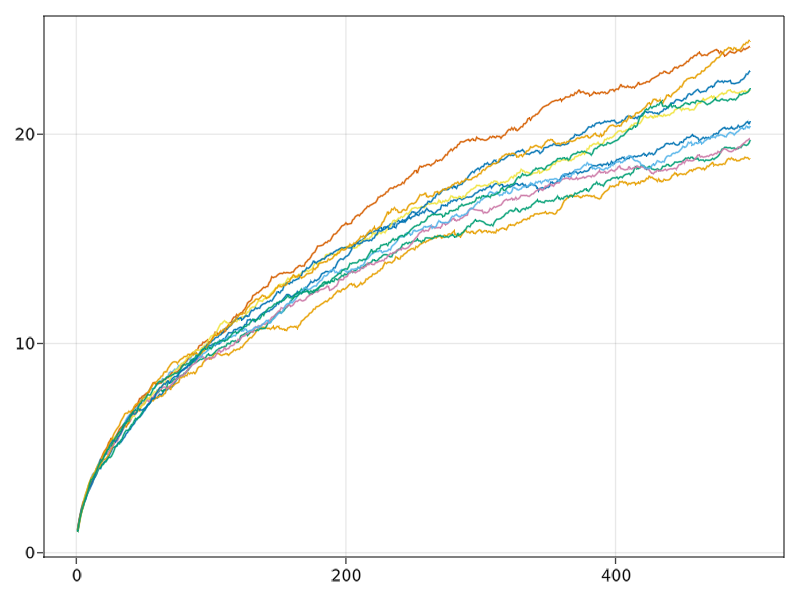

In [199]:
using CairoMakie
#delete 0 timestep before plotting since log(0) not defined.
f = Figure()
#Axis(f[1, 1],yscale=log10,xscale=log10)
Axis(f[1,1])
lines!(MSDS.ens_1)
lines!(MSDS.ens_2)
lines!(MSDS.ens_3)
lines!(MSDS.ens_4)
lines!(MSDS.ens_5)
lines!(MSDS.ens_6)
lines!(MSDS.ens_7)
lines!(MSDS.ens_8)
lines!(MSDS.ens_9)
lines!(MSDS.ens_10)
f
## 
#= 05.10 10:45
## Rohdaten gut aufbewahren, sinnvolle beschriftungen  
## Drei mal für klein 100, mittel300, groß1000 ,a 50 mal begrenzte randbedingungen, seed funktion?!
## stdabweichung (korridor) 


## Periodischen Randbedingugen mit in microtubuli modell

=#

## Github  

In [3]:
# Interactive exploration:
using Statistics
using CairoMakie
using InteractiveDynamics
using GLMakie
# parameter Range for sliders
model = initialize(; numagents = 600,Nstarts=4)

parange = Dict(
    :Nstarts => 1:30,
    :numagents => 100:1000,
    :p_hyd =>0.0:0.01:1.0, 
    :p_polym => 0.0:0.01:1.0, 
    :p_depolym_GTP =>0.0:0.01:1.0,
    :p_depolym_GDP => 0.0:0.01:1.0,)


groupcolor(a) = a.polym == true ? :red : :blue
groupmarker(a) = a.GDP == true ? :circle : '○'


adata = [(:polym,sum), (:GDP,sum)]
alabels = ["Polimerized", "Hydrolized"]



figure, adf, mdf = abm_data_exploration( 
    model, agent_step!, model_step!, parange;
    ac = groupcolor, am = groupmarker, as = 10,
    adata, alabels
)



LoadError: UndefVarError: initialize not defined